In [1]:
import os
import numpy as np
import osmnx as ox
import swifter
import networkx as nx
from matplotlib.collections import LineCollection
import pandas as pd
import math
from dotmap import DotMap
cwd = os.getcwd()

In [1]:
import os
print(os.environ['PATH'])

/Users/rkucharski/anaconda3/envs/MaaSSim/bin:/Users/rkucharski/anaconda3/condabin:/usr/bin:/bin:/usr/sbin:/sbin


In [2]:
os.getcwd()

'/Users/rkucharski/Documents/GitHub/ExMAS/ExMAS/spinoffs/tndp'

In [3]:
# df = pd.read_csv("ret.csv")
# df.efficient = df.efficient.fillna(False)
# df[df.efficient].utilities

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils

In [6]:
from ExMAS.utils import inData as inData

In [7]:
from ExMAS.transit import *

### prepare

### run

In [14]:
params = ExMAS.utils.get_config('ExMAS/data/configs/default.json')  # load the default


from ExMAS.utils import inData as inData

inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph


params.nP = 100
params.simTime = 1
params.speeds.ride = 8
params.mode_choice_beta = -0.5
params.speeds.walk = 1.2
params.walk_discomfort = 2
params.delay_value = 1.5
params.walk_threshold = 600
params.shared_discount = 0.2
params.s2s_discount = 0.6
inData.params = params

inData = ExMAS.utils.generate_demand(inData, params)

inData = ExMAS.main(inData, params, plot=False)
inData.sblts.rides['degree'] = inData.sblts.rides.apply(lambda x: len(x.indexes), axis=1)

inData.skims = DotMap()
inData.skims.dist = inData.skim.copy()
inData.skims.ride = inData.skims.dist.divide(params.speeds.ride).astype(int).T
inData.skims.walk = inData.skims.dist.divide(params.speeds.walk).astype(int).T
inData.skims.walk = inData.skims.walk.mask(inData.skims.walk > params.walk_threshold, np.inf)

inData.sblts.rides['origins'] = inData.sblts.rides.apply(
    lambda ride: list(inData.sblts.requests.loc[ride.indexes_orig].origin), axis=1)
inData.sblts.rides['destinations'] = inData.sblts.rides.apply(
    lambda ride: list(inData.sblts.requests.loc[ride.indexes_dest].destination), axis=1)
inData.sblts.rides['deps'] = inData.sblts.rides.apply(
    lambda ride: list(inData.sblts.requests.loc[ride.indexes_orig].treq), axis=1)
inData.sblts.rides['dep_deltas'] = inData.sblts.rides.apply(lambda ride: list(
    inData.sblts.requests.loc[ride.indexes_orig].treq - inData.sblts.requests.loc[ride.indexes_orig].treq.mean()),
                                                            axis=1)

inData.sblts.rm = ExMAS.utils.make_traveller_ride_matrix(inData)
inData.sblts.rm['exp_u_private'] = (inData.sblts.rm.u * params.mode_choice_beta).apply(math.exp)
inData.sblts.rm['exp_u_d2d'] = (inData.sblts.rm.u_sh * params.mode_choice_beta).apply(math.exp)
inData.sblts.rm['sum_exp'] = inData.sblts.rm['exp_u_d2d'] + inData.sblts.rm['exp_u_private']

09-06-21 14:12:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
09-06-21 14:12:21-INFO-creating combinations
09-06-21 14:12:21-INFO-9900	 nR*(nR-1)
09-06-21 14:12:21-INFO-Reduction of feasible pairs by 99.96%
09-06-21 14:12:21-INFO-Degree 2 	Completed
09-06-21 14:12:21-INFO-trips to extend at degree 2 : 17
09-06-21 14:12:21-INFO-At degree 2 feasible extensions found out of 0 searched
09-06-21 14:12:21-INFO-Degree 3 	Completed
09-06-21 14:12:21-INFO-No more trips to exted at degree 3
09-06-21 14:12:21-INFO-Matching 100 trips to 117 rides in order to min u_veh
09-06-21 14:12:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         30,495 
reduced by matching to:               29,290
09-06-21 14:12:21-INFO-Calculations  completed
09-06-21 14:12:21-INFO-DotMap(VehHourTrav=29200, VehHourTrav_ns=30495, PassHourTrav=31069, PassHourTrav_ns=30495, PassUtility=470.041475, PassUtility_ns=473.18999999999994, mean_lambda=0.21529390745041987, revenue_s=3659

In [36]:
pd.DataFrame.from_records(ret)

,indexes,origin,destination,treq,ttrav,df,efficient,transitizable,dist
0,[0],NaN,NaN,NaN,NaN,None,False,False,NaN
1,[1],NaN,NaN,NaN,NaN,None,False,False,NaN
2,[2],NaN,NaN,NaN,NaN,None,False,False,NaN
3,[3],NaN,NaN,NaN,NaN,None,False,False,NaN
4,[4],NaN,NaN,NaN,NaN,None,False,False,NaN
...,...,...,...,...,...,...,...,...,...
112,"[88, 91]",NaN,NaN,NaN,NaN,None,False,False,NaN
113,"[38, 44]",NaN,NaN,NaN,NaN,None,False,False,NaN
114,"[39, 41]",NaN,NaN,NaN,NaN,None,False,False,NaN
115,"[80, 87]",NaN,NaN,NaN,NaN,None,False,False,NaN


In [34]:
second_level_rides = pd.DataFrame.from_records(ret)
pd.concat(second_level_rides[second_level_rides.transitizable].df.values)

,ride,exp_u_private,exp_u_d2d,sum_exp,u,u_sh,origin,destination,dist,VoT,orig_walk_time,delay,dest_walk_time,s2s_ttrav,u_s2s,exp_u_s2s,prob_s2s,efficient
68,107,0.018826,0.019109,0.053976,7.945,7.915163,1668136725,44836969,4102,0.0035,422.0,12.0,88.0,473,8.26525,0.016041,0.297181,False
73,107,0.021195,0.025536,0.076487,7.708,7.335313,1566353694,44840841,3979,0.0035,320.0,12.0,24.0,473,7.02945,0.029756,0.389033,True


In [15]:
ret = inData.sblts.rides.swifter.apply(lambda x: transitize(inData, x), axis = 1)

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

09-06-21 14:12:23-WARNING-Transitization of pooled ride: 100 of degree: 2
09-06-21 14:12:23-INFO-no common origin pick-up point
09-06-21 14:12:23-WARNING-Transitization of pooled ride: 101 of degree: 2
09-06-21 14:12:23-INFO-no common origin pick-up point
09-06-21 14:12:23-WARNING-Transitization of pooled ride: 102 of degree: 2
09-06-21 14:12:23-INFO-no common origin pick-up point
09-06-21 14:12:23-WARNING-Transitization of pooled ride: 103 of degree: 2
09-06-21 14:12:23-INFO-no common origin pick-up point
09-06-21 14:12:23-WARNING-Transitization of pooled ride: 104 of degree: 2
09-06-21 14:12:23-INFO-no common origin pick-up point
09-06-21 14:12:23-WARNING-Transitization of pooled ride: 105 of degree: 2
09-06-21 14:12:23-INFO-no common origin pick-up point
09-06-21 14:12:23-WARNING-Transitization of pooled ride: 106 of degree: 2
09-06-21 14:12:23-INFO-no common origin pick-up point
09-06-21 14:12:23-WARNING-Transitization of pooled ride: 107 of degree: 2
09-06-21 14:12:23-INFO-Transit

In [28]:
df = pd.DataFrame.from_records(ret)
df[df.transitizable].df

107        ride  exp_u_private  exp_u_d2d   sum_exp  ...
Name: df, dtype: object

In [12]:
inData.transitize.second_level_rides = dict()  # pooled d2d rides transitized to s2s
inData.transitize.rm = list() # ride - traveller data on transitizable rides

# main loop
for i, ride in inData.sblts.rides.iterrows():  # loop over rides
    inData.transitize.second_level_rides[ride.name] = transitize(inData, ride, plot=False)  # see if it can be tranzitizabled
    if inData.transitize.second_level_rides[ride.name]['transitizable']:  # if so, add resulting dataframe for rm matrix
        inData.transitize.rm.append(inData.transitize.second_level_rides[ride.name]['df'])

08-06-21 12:38:42-WARNING-Transitization of pooled ride: 200 of degree: 2
08-06-21 12:38:42-WARNING-no common origin pick-up point
08-06-21 12:38:42-WARNING-Transitization of pooled ride: 201 of degree: 2
08-06-21 12:38:42-WARNING-no common origin pick-up point
08-06-21 12:38:42-WARNING-Transitization of pooled ride: 202 of degree: 2
08-06-21 12:38:42-WARNING-no common origin pick-up point
08-06-21 12:38:42-WARNING-Transitization of pooled ride: 203 of degree: 2
08-06-21 12:38:42-WARNING-no common origin pick-up point
08-06-21 12:38:42-WARNING-Transitization of pooled ride: 204 of degree: 2
08-06-21 12:38:42-WARNING-no common origin pick-up point
08-06-21 12:38:42-WARNING-Transitization of pooled ride: 205 of degree: 2
08-06-21 12:38:42-WARNING-no common destination pick-up point
08-06-21 12:38:42-WARNING-Transitization of pooled ride: 206 of degree: 2
08-06-21 12:38:42-WARNING-no common origin pick-up point
08-06-21 12:38:42-WARNING-Transitization of pooled ride: 207 of degree: 2
08-0

KeyboardInterrupt: 

In [26]:
ret['df']

,exp_u_private,exp_u_d2d,sum_exp,u,u_sh,origin,destination,dist,VoT,orig_walk_time,delay,dest_walk_time,d2d_ttrav,u_s2s,exp_u_s2s,prob_s2s
217,0.005859,0.009336,0.016693,10.2795,9.34780,549099463,1448535785,5306,0.0035,423.0,11.0,594.0,578,13.007575,0.001498,0.089725
233,0.011252,0.012337,0.033921,8.9745,8.79025,3669138214,44729058,4632,0.0035,226.0,12.0,296.0,578,9.145000,0.010332,0.304593


In [24]:
pd.concat([ret['df'],ret['df']])

,exp_u_private,exp_u_d2d,sum_exp,u,u_sh,origin,destination,dist,VoT,orig_walk_time,delay,dest_walk_time,d2d_ttrav,u_s2s,exp_u_s2s,prob_s2s
217,0.005859,0.009336,0.016693,10.2795,9.34780,549099463,1448535785,5306,0.0035,423.0,11.0,594.0,578,13.007575,0.001498,0.089725
233,0.011252,0.012337,0.033921,8.9745,8.79025,3669138214,44729058,4632,0.0035,226.0,12.0,296.0,578,9.145000,0.010332,0.304593
217,0.005859,0.009336,0.016693,10.2795,9.34780,549099463,1448535785,5306,0.0035,423.0,11.0,594.0,578,13.007575,0.001498,0.089725
233,0.011252,0.012337,0.033921,8.9745,8.79025,3669138214,44729058,4632,0.0035,226.0,12.0,296.0,578,9.145000,0.010332,0.304593


In [14]:
reqs = inData.sblts.requests.loc[ride.indexes]
reqs

,index,origin,destination,treq,tdep,ttrav,tarr,tdrop,dist,pax_id,VoT,delta,u,u_PT,ride_id,ttrav_sh,u_sh,kind,position
217,207,549099463,1448535785,2697,NaN,663,2021-06-03 16:43:28,NaN,5306,207,0.0035,371.769231,10.2795,999999,703,829,10.220263,20,0
233,22,3669138214,44729058,2917,NaN,579,2021-06-03 16:35:54,NaN,4632,22,0.0035,324.494505,8.9745,999999,1320,772,8.693562,42,2


In [17]:
inData.sblts.rm.loc[ride.name, :]

,ride,traveller,shared,degree,treq,ride_time,dist,ttrav,ttrav_sh,delay,u,u_sh,exp_u_private,exp_u_d2d,sum_exp
217,308,217,True,2,2697,888,5306,663,740,60.0,10.2795,9.34780,0.005859,0.009336,0.015195
233,308,233,True,2,2917,888,4632,579,758,-45.0,8.9745,8.79025,0.011252,0.012337,0.023589


In [21]:
ride = inData.sblts.rides.loc[308]
ret = transit.transitize(inData, ride, plot=False)

03-06-21 12:27:58-WARNING-Transitization of pooled ride: 308 of degree: 2
03-06-21 12:27:58-WARNING-Transitizing ride: 308 	 Common orig points:27,  dest points: 26
03-06-21 12:27:58-WARNING-	 ride: 308 	 exploring 0-th origin: 44868297
03-06-21 12:27:58-WARNING-	 ride: 308 	 Best departure time 3217 in range [2697,3516]
03-06-21 12:27:58-WARNING-	 Best solution -inf improved to 0.1164. 
 	 orig:44868297 dep:3516 dest:44729070
03-06-21 12:27:58-WARNING-	 Best solution 0.1164 improved to 0.1623. 
 	 orig:44868297 dep:3516 dest:44729072
03-06-21 12:27:58-WARNING-	 Best solution 0.1623 improved to 0.1698. 
 	 orig:44868297 dep:3516 dest:1402734506
03-06-21 12:27:58-WARNING-	 Best solution 0.1698 improved to 0.1746. 
 	 orig:44868297 dep:3516 dest:1402734511
03-06-21 12:27:58-WARNING-	 ride: 308 	 exploring 1-th origin: 298509326
03-06-21 12:27:59-WARNING-	 ride: 308 	 Best departure time 3139 in range [2697,3516]
03-06-21 12:27:59-WARNING-	 Best solution 0.1746 improved to 0.2259. 
 	 ori

In [39]:
ret

{'transitizable': True,
 'orig': 339548365,
 'dest': 1667696850,
 'dep': 2094,
 'orig_walk_times': 1667696850      0.0
 44720256      371.0
 Name: dest_walk_time, dtype: float64,
 'utilities': 115    7.899625
 122    9.360425
 Name: u_s2s, dtype: float64,
 'efficient': False}

In [36]:
ride = inData.sblts.rides.loc[309]
reqs = inData.sblts.requests.loc[ride.indexes]
rm = inData.sblts.rm.loc[ride.name, :][['exp_u_private', 'exp_u_d2d', 'sum_exp', 'u', 'u_sh']].join(
        reqs[['origin', 'destination', 'dist', 'VoT']])
rm['u_s2s'] = ret['utilities']
rm['efficient'] = rm['u_s2s']<=rm['u']


False

In [28]:
inData.sblts.requests.loc[RIDE.indexes]

,index,origin,destination,treq,tdep,ttrav,tarr,tdrop,dist,pax_id,VoT,delta,u,u_PT,ride_id,ttrav_sh,u_sh,kind,position
324,270,44839201,565046993,2999,NaN,541,2021-04-09 16:32:16,NaN,4332,270,0.0035,303.593407,8.3915,999999,2186,653,7.939488,30,0
301,91,44827071,643586468,2881,NaN,534,2021-04-09 16:29:25,NaN,4279,91,0.0035,299.967033,8.2875,999999,2098,737,8.190962,30,2
351,247,4407956433,1584502763,3190,NaN,556,2021-04-09 16:37:24,NaN,4449,247,0.0035,311.703297,8.6195,999999,1891,697,7.992950,21,0


In [29]:
inData.transits.loc[RIDEID:RIDEID]

,transitizable,orig,dest,orig_walk_times,dest_walk_times,arrivals,indexes,deps,origins
2189,True,44831440.0,643586468.0,"[202.0, 275.0, 305.0]","[0.0, 334.0, 365.0]","[3201.0, 3156.0, 3495.0]","[324, 301, 351]","[2999, 2881, 3190]","[44839201, 44827071, 4407956433]"


{'transitizable': True,
 'orig': 44831440,
 'dest': 643586468,
 'orig_walk_times': array([202., 275., 305.]),
 'dest_walk_times': array([  0., 334., 365.]),
 'arrivals': array([3201., 3156., 3495.])}

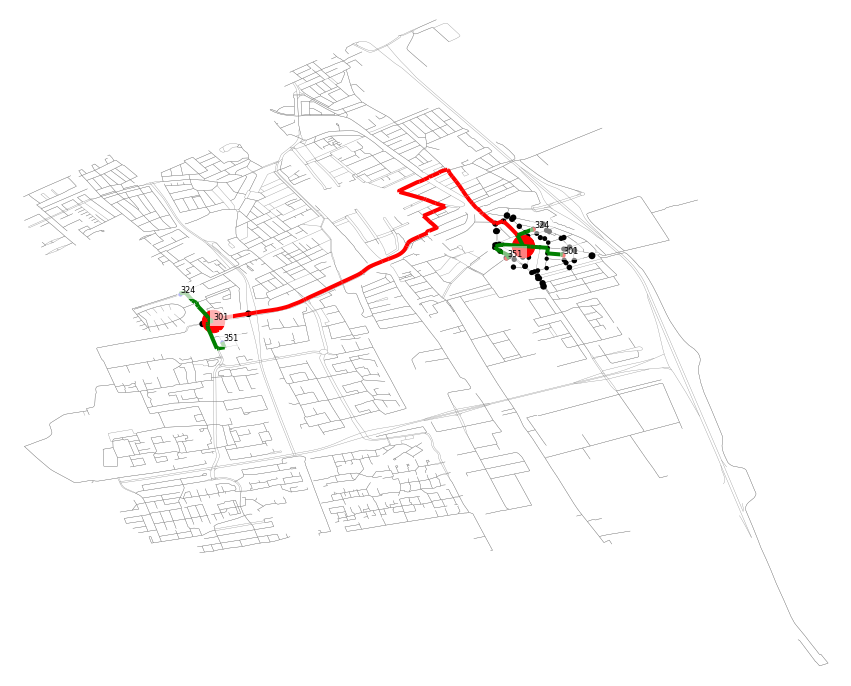

In [30]:
transitize(inData, RIDE, plot = True)

In [2]:
import math
math.log(2)

0.6931471805599453

In [31]:
inData.sblts.rm[inData.sblts.rm.ride == RIDEID]

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
2189 324  2189        324    True       3  2999       812  4332    541   
     301  2189        301    True       3  2881       812  4279    534   
     351  2189        351    True       3  3190       812  4449    556   

          ttrav_sh  delay       u      u_sh  exp_u_private  exp_u_d2d  \
2189 324       712  -86.5  8.3915  7.812087       0.015059   0.020120   
     301       642  101.5  8.2875  7.968012       0.015863   0.018611   
     351       651 -116.5  8.6195  8.483213       0.013437   0.014384   

           sum_exp  
2189 324  0.035179  
     301  0.034474  
     351  0.027821

In [50]:
def transitize_opt(inData, ride, plot = False):
    
    def utility_s2s(ride):
        # utility of shared trip i
        return (params.price * (1 - params.s2s_discount) * ride.dist / 1000 +
                ride.VoT * params.WtS * (ride.d2d_ttrav + params.delay_value * ride.delay) + 
                ride.VoT * params.walk_discomfort * (ride.orig_walk_time+ride.dest_walk_time))

    
    reqs = inData.sblts.requests.loc[ride.indexes]
    rm = inData.sblts.rm.loc[ride.name, :][['exp_u_private','exp_u_d2d','sum_exp']].join(reqs[['origin','destination','dist', 'VoT']])
  
    transitizable = True
    ret = {"transitizable":False, 
           'orig':None, 
           'dest':None,
          "orig_walk_times":list(),
          'orig_walk_times':list()}
    
    # only pooled rides
    if ride.degree==1:
        return ret
    
    # see if there is a common pickup point
    orig_catchments = inData.skims.walk.loc[ride.origins]
    orig_common_catchment = orig_catchments.loc[:,orig_catchments.sum()<np.inf]
    if orig_common_catchment.shape[1]==0:
        return ret
    
    # see if there is a common dropoff point
    dest_catchments = inData.skims.walk.loc[ride.destinations]
    #dest_catchments = dest_catchments.mask(dest_catchments> params.walk_threshold, np.inf)
    dest_common_catchment = dest_catchments.loc[:,dest_catchments.sum()<np.inf]
    if dest_common_catchment.shape[1]==0:
        return ret
    
    
            
    #explore
    origs_list = orig_common_catchment.columns.to_list()
    dests_list = dest_common_catchment.columns.to_list()
    treqs = reqs.set_index('origin').treq
    early = treqs.min()
    late = treqs.max()

    solution = None
    best_logsum = -np.inf
    ret = list()
    for orig in origs_list:
        print(orig)
        orig_walks = orig_common_catchment[orig]
        orig_walks.name = 'orig_walk_time' 
        df_o = rm.join(orig_walks,on = 'origin')
        for dep in range(early, late+100):
            delays = abs(dep-orig_walks-treqs)
            delays.name = 'delay'
            df_o_t =  df_o.join(delays,on = 'origin')
            for dest in dest_common_catchment:                
                dest_walks = dest_common_catchment[dest]
                dest_walks.name = 'dest_walk_time'
                df_o_t_d =  df_o_t.join(dest_walks,on = 'destination') 
                df_o_t_d['d2d_ttrav'] = inData.skims.ride.loc[orig,dest]
                df_o_t_d['u_s2s'] = df_o_t_d.apply(utility_s2s, axis = 1)
                df_o_t_d['exp_u_s2s'] = (df_o_t_d.u_s2s*params.mode_choice_beta).apply(math.exp)
                df_o_t_d['sum_exp'] = df_o_t_d['exp_u_s2s']+df_o_t_d['sum_exp']
                df_o_t_d['prob_s2s'] = df_o_t_d['exp_u_s2s']/df_o_t_d['sum_exp']
                logsum = df_o_t_d['prob_s2s'].sum()
                ret.append([orig, dest, dep, logsum, orig_walks, dest_walks, delays, df_o_t_d['u_s2s'].sum()])
                if logsum>best_logsum:
                    solution = [orig, dest, dep, orig_walks, dest_walks, delays]
                    print(orig, dest, dep, logsum, df_o_t_d['u_s2s'].sum())
                    best_logsum = logsum
    
    return solution, ret


solution, ret = transitize_opt(inData, RIDE, plot = True)

44843122
44843122 1413910851 2881 0.16400002856822088 41.959775
44843122 1413910852 2881 0.16711935508874576 42.042025
44843122 643586468 2881 0.2371758376465117 38.19097500000001
44843122 643586468 2882 0.23789160717101088 38.170500000000004
44843122 643586468 2883 0.23860925652559814 38.15002500000001
44843122 643586468 2884 0.2393287889977132 38.12955
44843122 643586468 2885 0.24005020787082706 38.109075000000004
44843122 643586468 2886 0.24077351642437492 38.0886
44843122 643586468 2887 0.24149871793368602 38.068125
44843122 643586468 2888 0.24222581566991588 38.047650000000004
44843122 643586468 2889 0.2429548128999757 38.027175
44843122 643586468 2890 0.24368571288646368 38.0067
44843122 643586468 2891 0.2444185188875947 37.986225000000005
44843122 643586468 2892 0.2451532341571299 37.96575000000001
44843122 643586468 2893 0.2458898619443073 37.945275
44843122 643586468 2894 0.24662840549376935 37.924800000000005
44843122 643586468 2895 0.24736886804549382 37.904325
44843122 6435

In [53]:
df = pd.DataFrame(ret, columns = ['orig','dest','dep','logsum','orig_walks', 'dest_walks', 'delays','u'])

In [62]:
df.groupby(['orig','dest']).logsum.min().unstack()

dest,643586468,643586473,643586490,643586567,1413910851,1413910852,1413910861
orig,,,,,,,
44812879,0.135852,0.047126,0.045095,0.048990,0.047150,0.046497,0.075304
44813598,0.168632,0.055574,0.052989,0.057765,0.055844,0.054757,0.094727
44814942,0.224868,0.082232,0.078551,0.085437,0.082299,0.081184,0.128083
44814943,0.226458,0.077211,0.073799,0.080228,0.077616,0.076108,0.129642
44816475,0.260485,0.091125,0.086930,0.094457,0.091590,0.089640,0.150754
...,...,...,...,...,...,...,...
4486831035,0.274810,0.103828,0.097315,0.107596,0.109247,0.107949,0.158145
5171875765,0.277969,0.204765,0.199450,0.211778,0.196572,0.200990,0.156653
5171875773,0.304740,0.255894,0.250237,0.263569,0.244712,0.250387,0.174959


<AxesSubplot:xlabel='dep'>

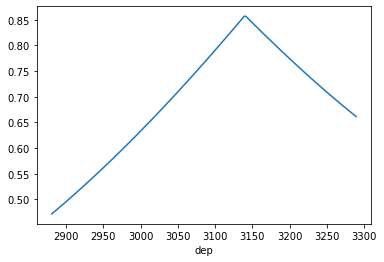

In [55]:
to_plot = df[df.orig == 44833188][df.dest==643586468].set_index('dep')
to_plot.logsum.plot()

In [89]:
orig, dest = 1436427208, 3377240345
inData.skims.ride.loc[dest, orig],inData.skims.ride.loc[orig, ]

(375, 362)

In [90]:
nx.shortest_path_length(inData.G, orig, dest, weight = 'length')/params.speeds.ride

375.92487500000004

In [64]:
early = treqs.min()
late = treqs.max()
early-orig_walks - treqs

1410536997   -656.0
1410536808   -389.0
4241243118   -972.0
dtype: float64

In [65]:
orig_walks

1410536997    463.0
1410536808    389.0
4241243118    400.0
Name: 44818490, dtype: float64

In [66]:
treqs

origin
1410536997    1912
1410536808    1719
4241243118    2291
Name: treq, dtype: int64

In [69]:
early

1719

In [67]:
early-orig_walks

1410536997    1256.0
1410536808    1330.0
4241243118    1319.0
Name: 44818490, dtype: float64

In [19]:
inData.transits[inData.transits.transitizable]

,transitizable,orig,dest,orig_walk_times,dest_walk_times,arrivals,indexes,deps,origins
505,True,4.485959e+07,1.421472e+09,"[456.0, 457.0]","[550.0, 429.0]","[3451.0, 3521.0]","[334, 344]","[2995, 3064]","[44852049, 1436427147]"
508,True,1.580652e+09,1.421472e+09,"[434.0, 382.0]","[277.0, 227.0]","[3624.0, 3446.0]","[357, 344]","[3190, 3064]","[1391417418, 1436427147]"
522,True,1.436427e+09,1.584563e+09,"[122.0, 241.0]","[217.0, 284.0]","[2334.0, 2871.0]","[241, 297]","[2212, 2630]","[44844494, 1435362510]"
552,True,1.413911e+09,1.558185e+09,"[127.0, 141.0]","[489.0, 477.0]","[3545.0, 3499.0]","[390, 384]","[3418, 3358]","[3669138213, 44852796]"
557,True,4.486073e+07,4.478636e+07,"[560.0, 556.0]","[0.0, 79.0]","[3274.0, 3564.0]","[303, 335]","[2714, 3008]","[44841581, 1530303653]"
...,...,...,...,...,...,...,...,...,...
3844,True,4.472320e+07,4.246177e+09,"[336.0, 129.0, 308.0, 427.0]","[311.0, 225.0, 45.0, 591.0]","[1996.0, 2096.0, 2190.0, 2569.0]","[182, 210, 199, 231]","[1660, 1967, 1882, 2142]","[672526443, 44723638, 1570983231, 44735538]"
3864,True,1.851747e+09,1.436427e+09,"[510.0, 245.0, 104.0, 589.0]","[499.0, 368.0, 198.0, 555.0]","[1329.0, 1172.0, 851.0, 1515.0]","[88, 101, 79, 100]","[819, 927, 747, 926]","[44833595, 1667696855, 1410536956, 5171875774]"
3875,True,1.851747e+09,1.436427e+09,"[510.0, 104.0, 245.0, 589.0]","[368.0, 499.0, 198.0, 555.0]","[1329.0, 851.0, 1172.0, 1515.0]","[88, 79, 101, 100]","[819, 747, 927, 926]","[44833595, 1410536956, 1667696855, 5171875774]"
3894,True,4.485730e+07,1.679761e+09,"[470.0, 51.0, 191.0, 226.0]","[348.0, 265.0, 331.0, 445.0]","[1153.0, 348.0, 880.0, 722.0]","[73, 28, 74, 46]","[683, 297, 689, 496]","[44838049, 44855153, 1413911113, 1413911117]"


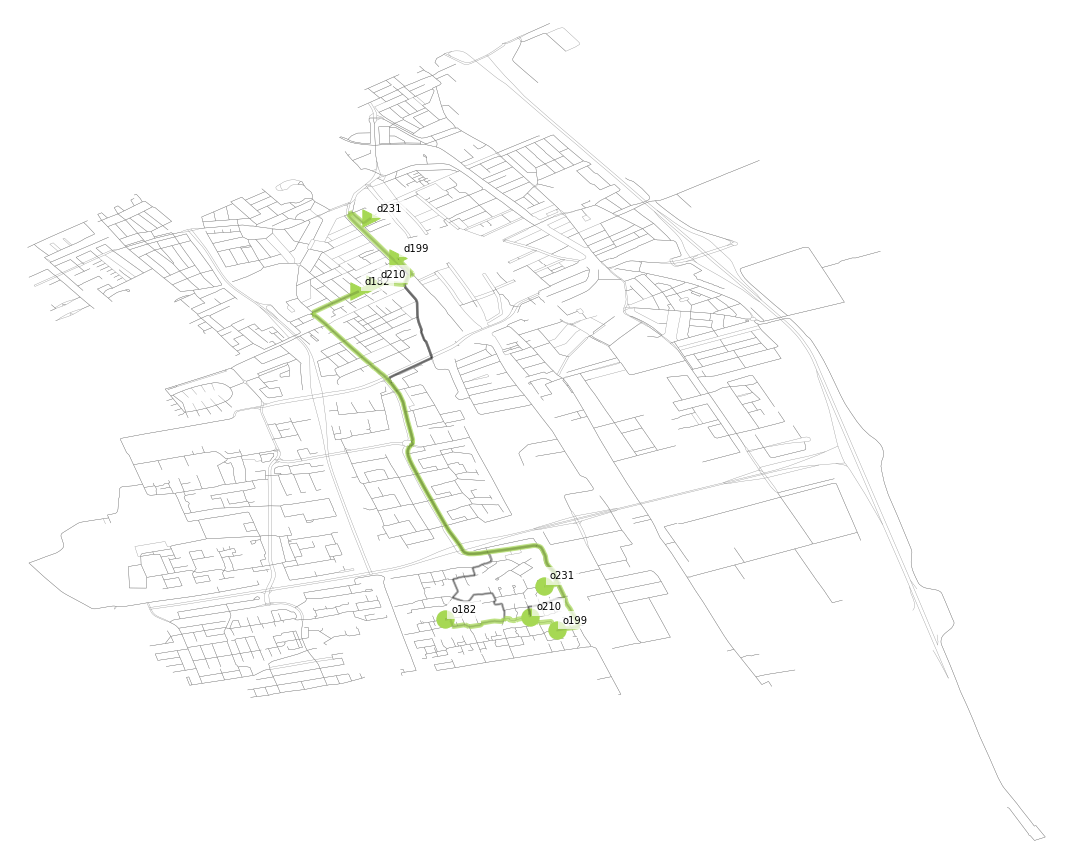

In [20]:
ExMAS.utils.plot_map_rides(inData, [3844], light=False, m_size=300, lw=5, fontsize = 10, figsize = (15,15))

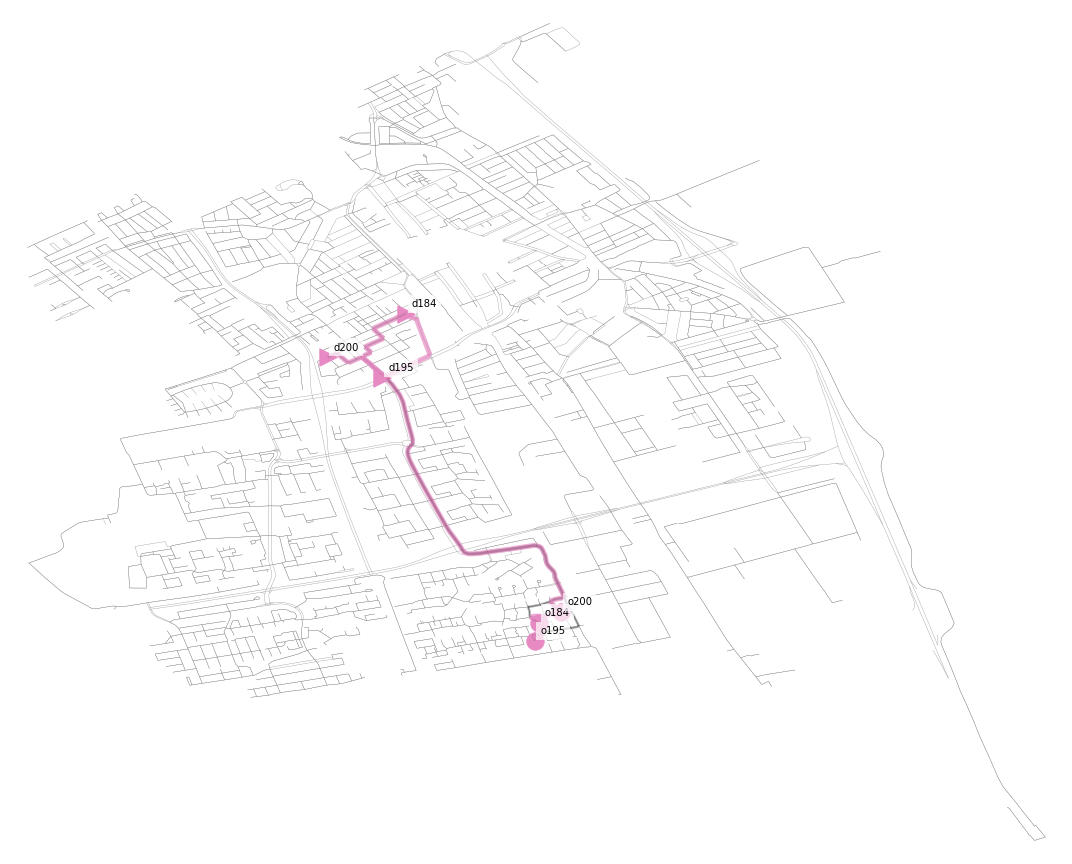

In [126]:
ExMAS.utils.plot_map_rides(inData, [2803], light=False, m_size=300, lw=5, fontsize = 10, figsize = (15,15))

In [22]:
inData.transits[inData.transits.transitizable]

,transitizable,orig,dest,orig_walk_times,dest_walk_times,arrivals,indexes,deps,origins
483,True,4.485729e+07,4.473685e+07,"[266.0, 263.0]","[225.0, 0.0]","[655.0, 472.0]","[40, 24]","[389, 209]","[44852052, 1413911096]"
516,True,1.435362e+09,1.421472e+09,"[574.0, 575.0]","[392.0, 467.0]","[1206.0, 1603.0]","[65, 109]","[632, 1028]","[1435362512, 1015968758]"
517,True,1.435362e+09,1.393025e+09,"[430.0, 575.0]","[501.0, 530.0]","[1140.0, 1603.0]","[77, 109]","[710, 1028]","[44852049, 1015968758]"
521,True,1.435362e+09,4.475350e+07,"[536.0, 575.0]","[71.0, 149.0]","[1591.0, 1603.0]","[116, 109]","[1055, 1028]","[1435362502, 1015968758]"
525,True,4.846026e+09,1.421472e+09,"[465.0, 345.0]","[465.0, 410.0]","[2038.0, 2233.0]","[169, 212]","[1573, 1888]","[1530303740, 44858065]"
...,...,...,...,...,...,...,...,...,...
3242,True,2.116560e+09,4.349049e+09,"[344.0, 315.0, 593.0]","[95.0, 204.0, 410.0]","[750.0, 649.0, 1002.0]","[43, 37, 45]","[406, 334, 409]","[44896906, 2323108577, 4846026470]"
3245,True,2.116560e+09,4.349049e+09,"[344.0, 46.0, 593.0]","[280.0, 75.0, 347.0]","[750.0, 161.0, 1002.0]","[43, 14, 45]","[406, 115, 409]","[44896906, 44891909, 4846026470]"
3252,True,5.820000e+08,1.576746e+09,"[580.0, 161.0, 387.0]","[369.0, 52.0, 440.0]","[580.0, 265.0, 486.0]","[0, 13, 12]","[0, 104, 99]","[2804747839, 44871804, 44869226]"
3266,True,1.569648e+09,1.010680e+09,"[105.0, 0.0, 118.0]","[483.0, 275.0, 577.0]","[2823.0, 2758.0, 3086.0]","[310, 315, 342]","[2718, 2758, 2968]","[582004773, 1569647770, 44812871]"


In [25]:
inData.transits.walk = inData.transits.apply(lambda x: sum(x.dest_walk_times) if x.transitizable else 0, axis = 1)
inData.transits.walk.sum()

245365.0

True

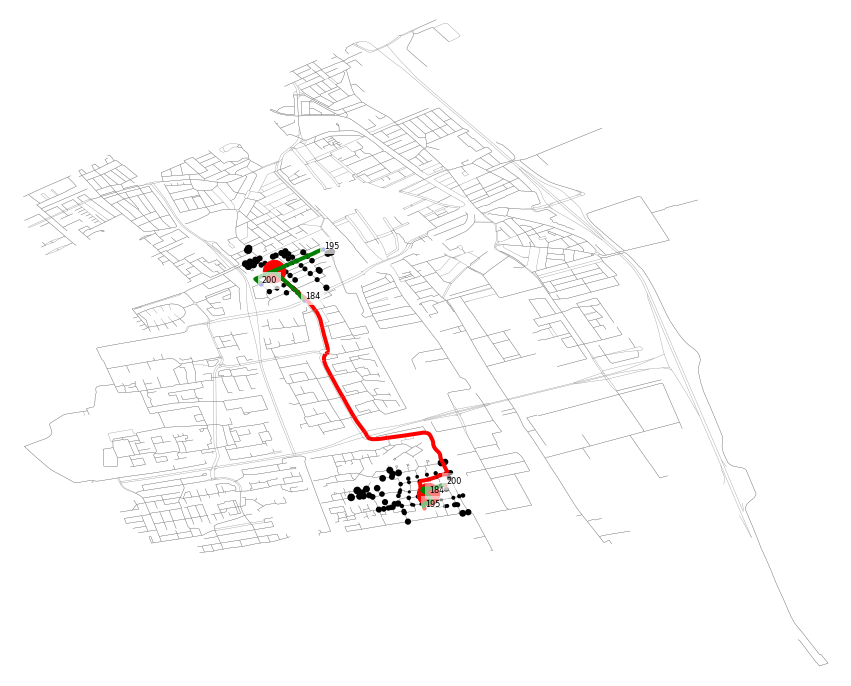

In [130]:
transitize(inData, inData.sblts.rides.iloc[2803], plot = True)

In [ ]:
arrivals = [1983.0, 2379.0]
deptimefun = lambda dep: sum([abs(dep - arrival)**2 for arrival in arrivals])  # minmax
deptimefun = np.vectorize(deptimefun)
x = np.arange(0, 3600, 1)
d = (deptimefun(x))
np.argmin(d)

In [ ]:
inData.transits[inData.transits.transitizable]

In [ ]:
tr = inData.transits[inData.transits.transitizable].sample(1).squeeze()
wait_times = tr.deps + tr.orig_walk_times
arrivals_times

In [ ]:
tr

In [ ]:
ride = inData.sblts.rides.loc[408]
orig_catchments = inData.skims.walk.loc[ride.origins]
orig_catchments = orig_catchments.mask(orig_catchments> params.walk_threshold, np.inf)
orig_common_catchment = orig_catchments.loc[:,orig_catchments.sum()<np.inf]
#(orig_common_catchment**2).sum().idxmin()

In [ ]:
(orig_common_catchment.T+ride.dep_deltas).T

In [ ]:
(orig_common_catchment**2).sum()

In [ ]:
ride

In [ ]:
nx.shortest_path_length(inData.G, 1668136733,1501364225,  weight='length')

In [ ]:
import networkx as nx
nx.shortest_path_length(inData.G, 44864523,44875781,  weight='length')

In [ ]:
deps = requests.loc[ride.indexes].treq
deps = deps - deps.min()
deps

In [ ]:
requests.loc[ride.indexes].treq

In [ ]:
inData.sblts.rides['origins'] = inData.sblts.rides.apply(lambda ride: list(inData.sblts.requests.loc[ride.indexes_orig].origin), axis = 1)
inData.sblts.rides['destinations'] = inData.sblts.rides.apply(lambda ride: list(inData.sblts.requests.loc[ride.indexes_dest].destination), axis = 1)

In [ ]:
inData.sblts.rides

In [ ]:
origins = requests.loc[ride.indexes_orig].origin
destinations = requests.loc[ride.indexes_dest].destination

In [ ]:
distances = skim.loc[origins.iloc[[0,1]]].sum(axis = 0)
middle = distances.argmin()
dist = distances.iloc[middle]
distances.index[middle]

In [ ]:
import pandas as pd

In [ ]:
#nc = ox.plot.get_node_colors_by_attr(G,'visits',num_bins = 5)
ids = inData.sblts.rides.iloc[-1].squeeze().indexes_orig
requests = inData.sblts.requests
skim = inData.skim

nodes = requests.loc[ids][column]  # set of nodes
deps = requests.loc[ids].treq
skim = skim/1000

distances = (skim.loc[nodes]**2).sum(axis = 0)
#square_distances = (skim.loc[nodes]**2).sum(axis = 0)
middle, distance = distances.idxmin(), distances.min()
distances = distances.apply(lambda x: 100/x if x<8000 else 0)
#distances = 10*distances/distances.mean()
d = dict()
for node in G.nodes:
    d[node] = distances[node]
    
fig, ax = ox.plot_graph(G,figsize = (15,15), node_size=pd.Series(d), node_color = 'black', edge_color='grey',  bgcolor='white', edge_linewidth=0.3,
                       show=False, close=False)
for i in ids:
    ax.scatter(G.nodes[nodes[i]]['x'], G.nodes[nodes[i]]['y'], s=10, c='red', marker='o')
    ax.annotate('node:{} dep:{}'.format(i,deps.loc[i]), (G.nodes[nodes[i]]['x'] + 0.0001, G.nodes[nodes[i]]['y'] +0.0001))
ax.scatter(G.nodes[middle]['x'], G.nodes[middle]['y'], s=30, c='blue', marker='o')
ax.annotate('middle:{}'.format(middle), (G.nodes[middle]['x'] + 0.0001, G.nodes[middle]['y'] +0.0001))


In [ ]:
def middle_point(inData, ids, column = 'origin', plot = False):
    
    requests = inData.sblts.requests
    skim = inData.skim
    
    nodes = requests.loc[ids][column]  # set of nodes
    deps = requests.loc[ids].treq

    distances = skim.loc[nodes].sum(axis = 0)
    square_distances = (skim.loc[nodes]**2).sum(axis = 0)
    middle, distance = distances.idxmin(), distances.min()

    
    print('For points {} nearest point is {} with distance {}'.format(ids, middle, distance))
    if plot:
        G = inData.G
        fig, ax = ox.plot_graph(G, figsize=(15, 15), node_size=0, edge_linewidth=0.3,
                                show=False, close=False,
                                edge_color='grey',  bgcolor='white')

        for i in ids:
            ax.scatter(G.nodes[nodes[i]]['x'], G.nodes[nodes[i]]['y'], s=10, c='red', marker='o')
            ax.annotate('node:{} dep:{}'.format(i,deps.loc[i]), (G.nodes[nodes[i]]['x'] + 0.0001, G.nodes[nodes[i]]['y'] +0.0001))

        ax.scatter(G.nodes[middle]['x'], G.nodes[middle]['y'], s=30, c='blue', marker='o')
        ax.annotate('middle:{}'.format(middle), (G.nodes[middle]['x'] + 0.0001, G.nodes[middle]['y'] +0.0001))
    
middle_point(inData, inData.sblts.rides.iloc[-1].squeeze().indexes_orig, plot = True)

In [ ]:
ids = inData.sblts.rides.iloc[-1].squeeze().indexes_orig
requests = inData.sblts.requests
skim = inData.skim
column = 'origin'
nodes = requests.loc[ids][column]  # set of nodes
deps = requests.loc[ids].treq
nodes
distances = skim.loc[nodes]**2
distances

In [ ]:
distances = skim.loc[nodes]**2

In [ ]:
distances

In [ ]:
skim.loc[nodes].sum().min()

In [ ]:
skim.iloc[761]

In [ ]:
inData.sblts.rides.iloc[-1]

In [ ]:
r = inData.sblts.requests
r.loc[ride.indexes_orig].origin

In [ ]:
RIDE = 414
ExMAS.utils.plot_map_rides(inData,[RIDE], light = False, m_size = 100)

ride 

In [ ]:
ride =inData.sblts.rides.sample(1).T
ride['d'] = ExMAS.utils.rides_DESCRIPTIONS
ride.columns = ['ride', 'description']
ride

selected rides in the solution

In [ ]:
inData.sblts.schedule.sample(5)

trips with parameters of the shared ride

In [ ]:
inData.sblts.requests

In [ ]:
trip =inData.sblts.requests.sample(1).T
trip['d'] = ExMAS.utils.trips_DESCRIPTIONS
trip.columns = ['ride', 'description']
trip

---
(c) Rafał Kucharski, Delft, 2020